In [ ]:
from keras.layers import Conv2D, UpSampling2D, Input
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, gray2rgb
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
import tensorflow as tf
import keras
import os
from keras.applications.vgg16 import VGG16

vggmodel=VGG16()


553467096/553467096 [==============================] - 3s 0us/step


In [ ]:
newmodel=Sequential()

for i, layer in enumerate (vggmodel.layers):
  if i<19: #Only up to 29th layer to include feature extraction only
    newmodel.add(layer)
newmodel.summary()
for layer in newmodel.layers:
  layer.trainable=True

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

In [ ]:
!unzip "/content/archive (19).zip" -d '/content/images/colorization3'


Archive:  /content/archive (19).zip
   creating: /content/images/colorization3/archive (15)/Images/
  inflating: /content/images/colorization3/archive (15)/Images/1000268201_693b08cb0e.jpg  
  inflating: /content/images/colorization3/archive (15)/Images/1001773457_577c3a7d70.jpg  
  inflating: /content/images/colorization3/archive (15)/Images/1002674143_1b742ab4b8.jpg  
  inflating: /content/images/colorization3/archive (15)/Images/1003163366_44323f5815.jpg  
  inflating: /content/images/colorization3/archive (15)/Images/1007129816_e794419615.jpg  
  inflating: /content/images/colorization3/archive (15)/Images/1007320043_627395c3d8.jpg  
  inflating: /content/images/colorization3/archive (15)/Images/1009434119_febe49276a.jpg  
  inflating: /content/images/colorization3/archive (15)/Images/1012212859_01547e3f17.jpg  
  inflating: /content/images/colorization3/archive (15)/Images/1015118661_980735411b.jpg  
  inflating: /content/images/colorization3/archive (15)/Images/1015584366_dfcec3c

In [ ]:
path ='/content/images/colorization3'
train_datagen =ImageDataGenerator(rescale=1. / 255)

train = train_datagen.flow_from_directory(path, target_size=(224, 224), batch_size=32, class_mode=None)

Found 608 images belonging to 1 classes.


In [ ]:
X =[]
Y =[]
for img in train[0]:
  try:
      lab = rgb2lab(img)
      X.append(lab[:,:,0])
      Y.append(lab[:,:,1:] / 128) #A and B values range from -127 to 128,
      #so we divide the values by 128 to restrict values to between -1 and 1.
  except:
     print('error')
X = np.array(X)
Y = np.array(Y)
X = X.reshape(X.shape+(1,)) #dimensions to be the same for X and Y
print(X.shape)
print(Y.shape)

(32, 224, 224, 1)
(32, 224, 224, 2)


In [ ]:
vggfeatures = []
for i, sample in enumerate(X):
  sample = gray2rgb(sample)
  sample = sample.reshape((1,224,224,3))
  prediction = newmodel.predict(sample)
  prediction = prediction.reshape((7,7,512))
  vggfeatures.append(prediction)
vggfeatures = np.array(vggfeatures)
print(vggfeatures.shape)

1/1 [==============================] - 0s 24ms/step
(32, 7, 7, 512)


In [ ]:
model=Sequential()
model.add(Conv2D(256, (3,3), activation='relu', padding='same', input_shape=(7,7,512)))
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3,3), activation= 'relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D (2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 7, 7, 256)         1179904   
                                                                 
 conv2d_13 (Conv2D)          (None, 7, 7, 128)         295040    
                                                                 
 up_sampling2d_10 (UpSampli  (None, 14, 14, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 14, 14, 64)        73792     
                                                                 
 up_sampling2d_11 (UpSampli  (None, 28, 28, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_15 (Conv2D)          (None, 28, 28, 32)       

In [ ]:
model.compile(optimizer='Adam', loss='mse' , metrics=['accuracy'])
history=model.fit(vggfeatures, Y, verbose=1, epochs=50, batch_size=128)

model.save('colorize_autoencoder_VGG162.model')

Epoch 1/50
1/1 [==============================] - 4s 4s/step - loss: 0.4174 - accuracy: 0.4409
Epoch 2/50
1/1 [==============================] - 0s 36ms/step - loss: 0.7196 - accuracy: 0.5987
Epoch 3/50
1/1 [==============================] - 0s 34ms/step - loss: 0.8539 - accuracy: 0.6021
Epoch 4/50
1/1 [==============================] - 0s 36ms/step - loss: 0.7234 - accuracy: 0.5970
Epoch 5/50
1/1 [==============================] - 0s 34ms/step - loss: 0.7838 - accuracy: 0.4837
Epoch 6/50
1/1 [==============================] - 0s 37ms/step - loss: 0.7140 - accuracy: 0.4198
Epoch 7/50
1/1 [==============================] - 0s 35ms/step - loss: 0.8165 - accuracy: 0.4155
Epoch 8/50
1/1 [==============================] - 0s 31ms/step - loss: 0.7396 - accuracy: 0.4133
Epoch 9/50
1/1 [==============================] - 0s 32ms/step - loss: 0.6657 - accuracy: 0.4117
Epoch 10/50
1/1 [==============================] - 0s 33ms/step - loss: 0.5258 - accuracy: 0.4160
Epoch 11/50
1/1 [==============

In [ ]:
import matplotlib.pyplot as plt

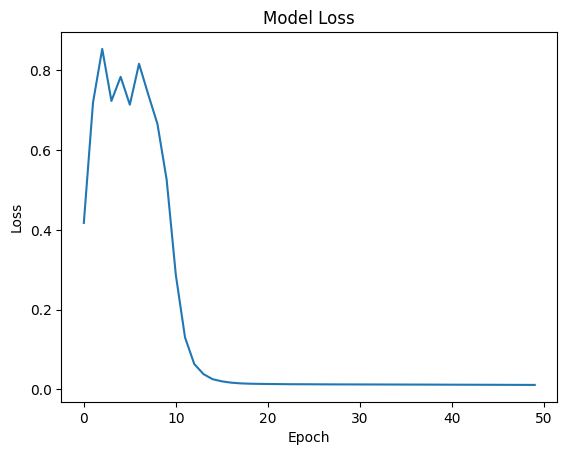

In [ ]:
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
model = tf.keras.models.load_model('colorize_autoencoder_VGG162.model',
                                   custom_objects=None,
                                   compile=True)



(1, 224, 224, 3)
1/1 [==============================] - 0s 199ms/step
(1, 224, 224, 2)


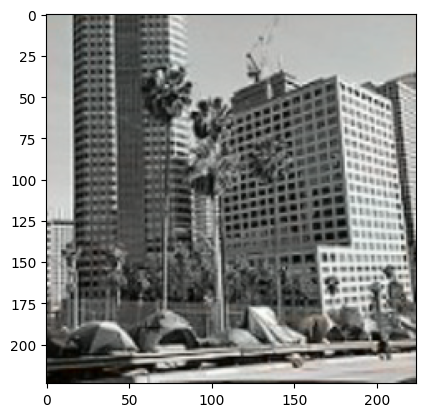

In [ ]:
testpath = '/content/images/colorization2/test_images/'
files = os.listdir(testpath)
for idx, file in enumerate(files):
    test = img_to_array(load_img(testpath+file))
    test = resize(test, (224,224), anti_aliasing=True)
    test*= 1.0/255
    lab = rgb2lab(test)
    l = lab[:,:,0]
    L = gray2rgb(l)
    L = L.reshape((1,224,224,3))
    print(L.shape)
    vggpred = newmodel.predict(L)
    ab = model.predict(vggpred)
    print(ab.shape)
    ab = ab*128
    cur = np.zeros((224, 224, 3))
    cur[:,:,0] = l
    cur[:,:,1:] = ab

    #outputLAB = (cur * [100, 255, 255]) - [0, 128, 128]#denormalization
    rgb_image = lab2rgb(cur)



    plt.imshow(rgb_image)
    plt.show()